# Convolutional Neural Networks for Image Classification

March, 2024
* Johanna Norell
* Andreas Helgesson
* Axel Blom

Using CNNs to classify medical images of skin markers as malignant or harmless cases by visual inspection.


# Preliminaries

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive/')

In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision

C:\Users\andre\anaconda3\envs\DAT341\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [ ]:
# Loading training images
folder = ImageFolder('a5_data/train', transform=torchvision.transforms.ToTensor())
train_loader = DataLoader(folder, batch_size=64, shuffle=True)

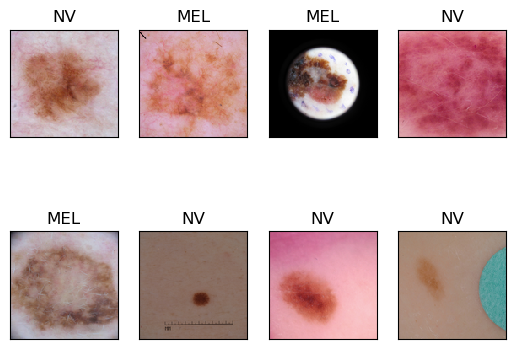

In [ ]:
# Visualize a random selection of the images
Xexamples, Yexamples = next(iter(train_loader))
for i in range(8):
    plt.subplot(2,4,i+1)
    img = Xexamples[i].numpy().transpose(1, 2, 0)
    plt.imshow(img, interpolation='none')
    plt.title('NV' if Yexamples[i] else 'MEL')
    plt.xticks([])
    plt.yticks([])

In [ ]:
# Getting the image sizes
image_size = Xexamples[0].size()
C, H, W = image_size
print(f"Image dimensions: Height = {H}, Width = {W}")

Image dimensions: Height = 128, Width = 128


In [ ]:
# Loading validation images
folder = ImageFolder('a5_data/val', transform=torchvision.transforms.ToTensor())
val_loader = DataLoader(folder, batch_size=64, shuffle=True)

# Implementing Classifier

## Baseline

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

In [ ]:
# Creating our baseline model based on best practices and our knowledge on image classification
class BaselineClassifier(nn.Module):

    def __init__(self):
        super().__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)

        # Flatten to 2 dimensions
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Compressing to our binary output
        self.fc1 = nn.Linear(16*32*32, 64)
        self.fc2 = nn.Linear(64, 2)

        # Activation function
        self.relu = nn.ReLU()

        # Reduce overfitting
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):

        # Apply convolutional layers adn pooling
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))

        # Flatten
        x = x.view(-1, 16*32*32)

        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [ ]:
# Create training function
def train_classifier(model, train_data, hyperparams):

    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=hyperparams['lr'])

    # Training loop
    for epoch in range(hyperparams['n_epochs']):

        model.train()
        loss_sum = 0

        for images, labels in tqdm(train_data, desc=f"Running Epoch {epoch+1}..."):

            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = loss_func(outputs, labels)

            # Backward
            loss.backward()
            optimizer.step()
            loss_sum += loss.item()

        # Save checkpoint https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
        #if epoch % 5 == 0:
        torch.save(model.state_dict(), f"checkpoints/{type(model).__name__}_checkpoint_epoch{epoch+1}.pth")

        print(f"Epoch {epoch+1} complete. Loss: {loss_sum}\n")


    # Save finished model https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
    #torch.save(model.state_dict(), f"/content/drive/MyDrive/DAT341/Assignment5/checkpoints/{type(model).__name__}.pth")

    print('Finished Training')

In [ ]:
# Create evaluation function
def evaluate_classifier(model, eval_data):

    model.eval()

    real = []
    pred = []

    for Xbatch, Ybatch in tqdm(eval_data, desc="Running evaluation..."):
        outputs = model(Xbatch)
        _, predictions = torch.max(outputs, 1)
        real.extend(Ybatch.numpy())
        pred.extend(predictions.numpy())

    return accuracy_score(real, pred)

### Running Baseline Model

With all the necessary functions defined, we can now create an instance of our baseline model, train it, and evaluate it on the validation data. It is important to note that training and evaluation is computationally expensive and very time consuming. We train the model for a few epochs and save a copy of it after each epoch:

In [ ]:
# Running the baseline model

# Create model
our_model = BaselineClassifier()
hyperparams = {
    'lr': 1e-3,
    'n_epochs': 10
    }

# Train model (Run with GPU!!)
train_classifier(model=our_model, train_data=train_loader, hyperparams=hyperparams)

Running Epoch 1...: 100%|██████████| 101/101 [00:10<00:00,  9.22it/s]


Epoch 1 complete. Loss: 50.755784928798676



Running Epoch 2...: 100%|██████████| 101/101 [00:11<00:00,  9.13it/s]


Epoch 2 complete. Loss: 43.79184424877167



Running Epoch 3...: 100%|██████████| 101/101 [00:11<00:00,  9.11it/s]


Epoch 3 complete. Loss: 42.798332542181015



Running Epoch 4...: 100%|██████████| 101/101 [00:10<00:00,  9.21it/s]


Epoch 4 complete. Loss: 41.06453886628151



Running Epoch 5...: 100%|██████████| 101/101 [00:11<00:00,  8.93it/s]


Epoch 5 complete. Loss: 41.46089258790016



Running Epoch 6...: 100%|██████████| 101/101 [00:11<00:00,  9.14it/s]


Epoch 6 complete. Loss: 40.17744240164757



Running Epoch 7...: 100%|██████████| 101/101 [00:11<00:00,  9.15it/s]


Epoch 7 complete. Loss: 38.85921409726143



Running Epoch 8...: 100%|██████████| 101/101 [00:11<00:00,  9.12it/s]


Epoch 8 complete. Loss: 37.443505734205246



Running Epoch 9...: 100%|██████████| 101/101 [00:11<00:00,  9.08it/s]


Epoch 9 complete. Loss: 37.83399663865566



Running Epoch 10...: 100%|██████████| 101/101 [00:11<00:00,  9.16it/s]

Epoch 10 complete. Loss: 36.317564621567726

Finished Training


We load each model copy/checkpoint and evaluate it on the training and validation data, and plot it in a graph. This way, we can determine an appropriate number of epochs in order to achieve good accuracy without introducing overfitting.

Running evaluation...: 100%|██████████| 20/20 [00:01<00:00, 13.83it/s]


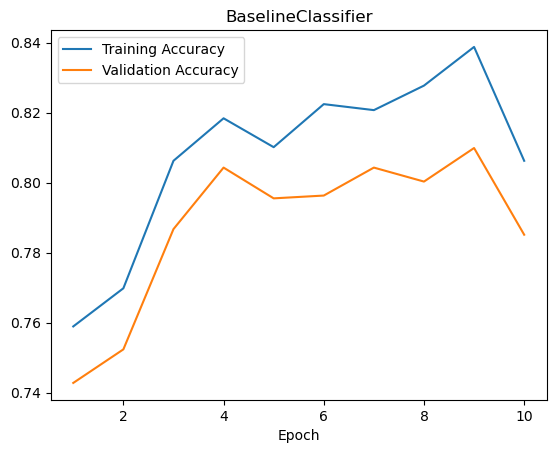

In [ ]:
import matplotlib.pyplot as plt

# Load in each model checkpoint, evaluate, and plot scores
training_score = []
validation_score = []

for i in range(1,11):
  # Load model
  loaded_model = BaselineClassifier()
  loaded_model.load_state_dict(torch.load(f"checkpoints/BaselineClassifier_checkpoint_epoch{i}.pth"))

  # Training data accuracy (can be run with just CPU!!)
  score = evaluate_classifier(loaded_model, train_loader)
  training_score.append(score)

  # Validation data accuracy (can be run with just CPU!!)
  score = evaluate_classifier(loaded_model, val_loader)
  validation_score.append(score)

plt.plot(range(1,11), training_score, label='Training Accuracy')
plt.plot(range(1,11), validation_score, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.title('BaselineClassifier')
plt.show()

baseline_validation_score = validation_score

In [ ]:
print(validation_score[3])

0.8115015974440895


We see that 4 epochs is suitable for this classifier, which yields an accuracy of 0.812 on the validation data without a lot of overfitting (according to the plot).

## Normalization

In [ ]:
# Classifier that inherits from the baseline, but adding batch normalization
class NormalizedClassifier(BaselineClassifier):

    def __init__(self):
        super().__init__()

        # Batch normalization
        self.bn1 = nn.BatchNorm2d(num_features=8)
        self.bn2 = nn.BatchNorm2d(num_features=16)

    def forward(self, x):

        # Apply convolutional layers and pooling and batching
        x = self.pool(self.bn1(self.relu(self.conv1(x))))
        x = self.pool(self.bn2(self.relu(self.conv2(x))))

        # Flatten
        x = x.view(-1, 16*32*32)

        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

### Running Normalization Model

In [ ]:
# Create model
our_model = NormalizedClassifier()
hyperparams = {
    'lr': 1e-3,
    'n_epochs': 10
    }

# Train model (Run with GPU when entire dataset!!)
train_classifier(model=our_model, train_data=train_loader, hyperparams=hyperparams)

Running Epoch 1...: 100%|██████████| 101/101 [00:12<00:00,  7.92it/s]


Epoch 1 complete. Loss: 53.987676560878754



Running Epoch 2...: 100%|██████████| 101/101 [00:12<00:00,  7.92it/s]


Epoch 2 complete. Loss: 42.199121937155724



Running Epoch 3...: 100%|██████████| 101/101 [00:12<00:00,  7.91it/s]


Epoch 3 complete. Loss: 39.650868862867355



Running Epoch 4...: 100%|██████████| 101/101 [00:12<00:00,  7.94it/s]


Epoch 4 complete. Loss: 38.312269657850266



Running Epoch 5...: 100%|██████████| 101/101 [00:12<00:00,  7.84it/s]


Epoch 5 complete. Loss: 36.08133962750435



Running Epoch 6...: 100%|██████████| 101/101 [00:12<00:00,  7.85it/s]


Epoch 6 complete. Loss: 34.892451122403145



Running Epoch 7...: 100%|██████████| 101/101 [00:12<00:00,  7.88it/s]


Epoch 7 complete. Loss: 32.84199211001396



Running Epoch 8...: 100%|██████████| 101/101 [00:12<00:00,  7.96it/s]


Epoch 8 complete. Loss: 32.07264243066311



Running Epoch 9...: 100%|██████████| 101/101 [00:12<00:00,  8.01it/s]


Epoch 9 complete. Loss: 31.127533808350563



Running Epoch 10...: 100%|██████████| 101/101 [00:12<00:00,  7.94it/s]


Epoch 10 complete. Loss: 29.167174495756626

Finished Training


Running evaluation...: 100%|██████████| 20/20 [00:01<00:00, 12.55it/s]


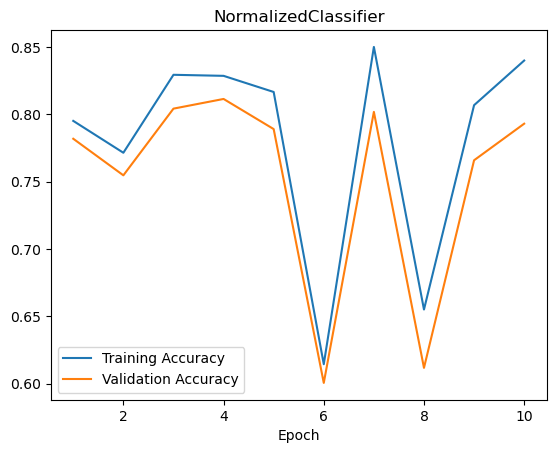

In [ ]:
# Load in each model checkpoint, evaluate, and plot scores
training_score = []
validation_score = []

for i in range(1,11):
  # Load model
  loaded_model = NormalizedClassifier()
  loaded_model.load_state_dict(torch.load(f"checkpoints/NormalizedClassifier_checkpoint_epoch{i}.pth"))

  # Training data accuracy (can be run with just CPU!!)
  score = evaluate_classifier(loaded_model, train_loader)
  training_score.append(score)

  # Validation data accuracy (can be run with just CPU!!)
  score = evaluate_classifier(loaded_model, val_loader)
  validation_score.append(score)

plt.plot(range(1,11), training_score, label='Training Accuracy')
plt.plot(range(1,11), validation_score, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.title('NormalizedClassifier')
plt.show()

normalized_validation_score = validation_score

In [ ]:
print(validation_score[0])

0.7819488817891374


We see that 1 epoch is enough for this classifier, which yields an accuracy of 0.782. Further epochs gives large variations in accuracy, and indicator of overfitting or otherwise poor performance.

## Residual Connections

In [ ]:
# Classifier that inherits from the baseline, but adding residual connection
class ResidualConnectionClassifier(BaselineClassifier):

    def __init__(self):
        super().__init__()

        self.onebyone = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=1)

    def forward(self, x):

        residual = x

        # Apply convolutional layers and pooling
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))

        # Resize residual and add
        residual = self.onebyone(residual)
        residual = self.pool(residual)
        residual = self.pool(residual)
        x += residual

        # Flatten
        x = x.view(-1, 16*32*32)

        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

## Running Residual Connections Model

In [ ]:
# Create model
our_model = ResidualConnectionClassifier()
hyperparams = {
    'lr': 1e-3,
    'n_epochs': 20
    }

# Train model (Run with GPU when entire dataset!!)
train_classifier(model=our_model, train_data=train_loader, hyperparams=hyperparams)

Running Epoch 1...: 100%|██████████| 101/101 [00:18<00:00,  5.42it/s]


Epoch 1 complete. Loss: 58.01141220331192



Running Epoch 2...: 100%|██████████| 101/101 [00:18<00:00,  5.39it/s]


Epoch 2 complete. Loss: 51.41177195310593



Running Epoch 3...: 100%|██████████| 101/101 [00:18<00:00,  5.39it/s]


Epoch 3 complete. Loss: 48.91816362738609



Running Epoch 4...: 100%|██████████| 101/101 [00:18<00:00,  5.44it/s]


Epoch 4 complete. Loss: 47.72290697693825



Running Epoch 5...: 100%|██████████| 101/101 [00:18<00:00,  5.43it/s]


Epoch 5 complete. Loss: 45.773589581251144



Running Epoch 6...: 100%|██████████| 101/101 [00:18<00:00,  5.38it/s]


Epoch 6 complete. Loss: 45.906841933727264



Running Epoch 7...: 100%|██████████| 101/101 [00:18<00:00,  5.39it/s]


Epoch 7 complete. Loss: 44.76775276660919



Running Epoch 8...: 100%|██████████| 101/101 [00:18<00:00,  5.37it/s]


Epoch 8 complete. Loss: 44.64218243956566



Running Epoch 9...: 100%|██████████| 101/101 [00:18<00:00,  5.37it/s]


Epoch 9 complete. Loss: 44.87781608104706



Running Epoch 10...: 100%|██████████| 101/101 [00:18<00:00,  5.39it/s]


Epoch 10 complete. Loss: 43.74125397205353



Running Epoch 11...: 100%|██████████| 101/101 [00:18<00:00,  5.37it/s]


Epoch 11 complete. Loss: 43.040642112493515



Running Epoch 12...: 100%|██████████| 101/101 [00:19<00:00,  5.30it/s]


Epoch 12 complete. Loss: 41.58632329106331



Running Epoch 13...: 100%|██████████| 101/101 [00:18<00:00,  5.33it/s]


Epoch 13 complete. Loss: 41.60993677377701



Running Epoch 14...: 100%|██████████| 101/101 [00:18<00:00,  5.41it/s]


Epoch 14 complete. Loss: 41.2278188765049



Running Epoch 15...: 100%|██████████| 101/101 [00:18<00:00,  5.35it/s]


Epoch 15 complete. Loss: 40.5682230591774



Running Epoch 16...: 100%|██████████| 101/101 [00:18<00:00,  5.45it/s]


Epoch 16 complete. Loss: 39.50947889685631



Running Epoch 17...: 100%|██████████| 101/101 [00:18<00:00,  5.42it/s]


Epoch 17 complete. Loss: 39.06781378388405



Running Epoch 18...: 100%|██████████| 101/101 [00:18<00:00,  5.37it/s]


Epoch 18 complete. Loss: 39.34812965989113



Running Epoch 19...: 100%|██████████| 101/101 [00:18<00:00,  5.41it/s]


Epoch 19 complete. Loss: 38.81872954964638



Running Epoch 20...: 100%|██████████| 101/101 [00:18<00:00,  5.43it/s]

Epoch 20 complete. Loss: 38.99553608894348

Finished Training


In [ ]:
# Load in each model checkpoint, evaluate, and plot scores
training_score = []
validation_score = []

for i in range(1,21):
  # Load model
  loaded_model = ResidualConnectionClassifier()
  loaded_model.load_state_dict(torch.load(f"checkpoints/ResidualConnectionClassifier_checkpoint_epoch{i}.pth"))

  # Training data accuracy (can be run with just CPU!!)
  score = evaluate_classifier(loaded_model, train_loader)
  training_score.append(score)

  # Validation data accuracy (can be run with just CPU!!)
  score = evaluate_classifier(loaded_model, val_loader)
  validation_score.append(score)

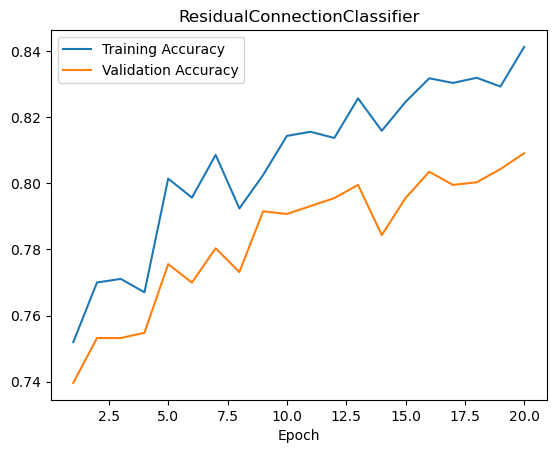

In [ ]:
plt.plot(range(1,21), training_score, label='Training Accuracy')
plt.plot(range(1,21), validation_score, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.title('ResidualConnectionClassifier')
plt.show()

residualconnection_validation_score = validation_score

In [ ]:
print(validation_score[15])

0.8035143769968051


Note that this classifier using residual was trained for 20 epochs, as no good conclusions could be drawn when running for just 10 epochs. We now see that there is a clear increase with increasing epoch in accuracy, but there does seem to be a bit of a leveling of after 15+ epoch. we therefore select 16 epochs for this classifier, which yields an accuracy of 0.804. This is many more epochs than previous classifiers needed.

## Data augmentation

In [ ]:
from torchvision import transforms, datasets

# Define our transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip the images horizontally
    transforms.RandomRotation(10),  # Randomly rotate the images by up to 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Randomly alter the brightness, contrast
    transforms.ToTensor(),  # Convert the images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

# Apply the transformations to your dataset
folder = datasets.ImageFolder("a5_data/train", transform=transform)

# Create the DataLoader
transformed_train_loader = DataLoader(folder, batch_size=64, shuffle=True)

In [ ]:
# Run the same basline classifier on this transformed data

# Create model
our_model = BaselineClassifier()
hyperparams = {
    'lr': 1e-3,
    'n_epochs': 10
    }

# Train model (Run with GPU!!)
train_classifier(model=our_model, train_data=transformed_train_loader, hyperparams=hyperparams)

Running Epoch 1...: 100%|██████████| 101/101 [00:14<00:00,  6.87it/s]


Epoch 1 complete. Loss: 54.703687250614166



Running Epoch 2...: 100%|██████████| 101/101 [00:14<00:00,  6.95it/s]


Epoch 2 complete. Loss: 48.220320880413055



Running Epoch 3...: 100%|██████████| 101/101 [00:14<00:00,  6.98it/s]


Epoch 3 complete. Loss: 45.36057439446449



Running Epoch 4...: 100%|██████████| 101/101 [00:14<00:00,  6.95it/s]


Epoch 4 complete. Loss: 43.424263924360275



Running Epoch 5...: 100%|██████████| 101/101 [00:15<00:00,  6.69it/s]


Epoch 5 complete. Loss: 42.28442391753197



Running Epoch 6...: 100%|██████████| 101/101 [00:14<00:00,  6.86it/s]


Epoch 6 complete. Loss: 39.995799481868744



Running Epoch 7...: 100%|██████████| 101/101 [00:14<00:00,  6.85it/s]


Epoch 7 complete. Loss: 39.618554413318634



Running Epoch 8...: 100%|██████████| 101/101 [00:14<00:00,  6.91it/s]


Epoch 8 complete. Loss: 39.33458623290062



Running Epoch 9...: 100%|██████████| 101/101 [00:14<00:00,  6.92it/s]


Epoch 9 complete. Loss: 38.47582344710827



Running Epoch 10...: 100%|██████████| 101/101 [00:14<00:00,  6.88it/s]


Epoch 10 complete. Loss: 38.533412113785744

Finished Training


Running evaluation...: 100%|██████████| 20/20 [00:01<00:00, 13.70it/s]


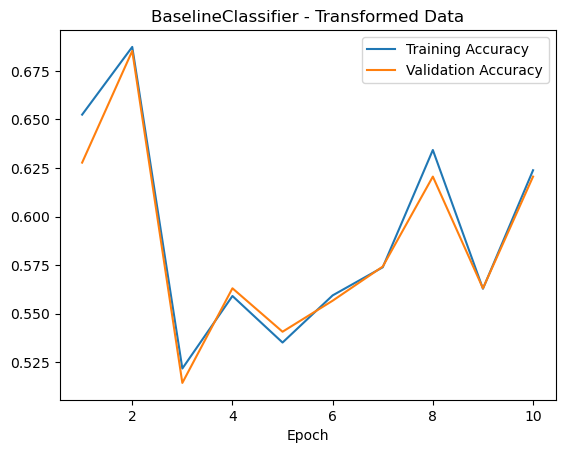

In [ ]:
# Load in each model checkpoint, evaluate, and plot scores
training_score = []
validation_score = []

for i in range(1,11):
  # Load model
  loaded_model = BaselineClassifier()
  loaded_model.load_state_dict(torch.load(f"checkpoints/BaselineClassifier_checkpoint_epoch{i}.pth"))

  # Training data accuracy (can be run with just CPU!!)
  score = evaluate_classifier(loaded_model, train_loader)
  training_score.append(score)

  # Validation data accuracy (can be run with just CPU!!)
  score = evaluate_classifier(loaded_model, val_loader)
  validation_score.append(score)

plt.plot(range(1,11), training_score, label='Training Accuracy')
plt.plot(range(1,11), validation_score, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.title('BaselineClassifier - Transformed Data')
plt.show()

transformed_validation_score = validation_score

In [ ]:
print(validation_score[1])

0.6853035143769968


We note that the model has a much lower accuracy than previous implementation, which is not surprising given that the training data has a lot more variations this time (due to the transformations). In any case, we see a high point after 2 epochs that yiels a an accuracy of 0.685.

## Transfer Learning

We use AlexNet beacuse it is so much faster than the other pre-trained models, and we are short on time. See https://towardsdatascience.com/the-w3h-of-alexnet-vggnet-resnet-and-inception-7baaaecccc96

In [ ]:
# Load pre-trained model
weights_id = torchvision.models.AlexNet_Weights.IMAGENET1K_V1
our_model = torchvision.models.alexnet(weights=weights_id)
hyperparams = {
    'lr': 1e-3,
    'n_epochs': 10
    }

# Train model with our data (Run with GPU when entire dataset!!)
train_classifier(model=our_model, train_data=train_loader, hyperparams=hyperparams)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\andre/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:07<00:00, 31.6MB/s] 
Running Epoch 1...: 100%|██████████| 101/101 [00:52<00:00,  1.92it/s]


Epoch 1 complete. Loss: 92.68767228722572



Running Epoch 2...: 100%|██████████| 101/101 [00:52<00:00,  1.94it/s]


Epoch 2 complete. Loss: 47.366062968969345



Running Epoch 3...: 100%|██████████| 101/101 [00:53<00:00,  1.88it/s]


Epoch 3 complete. Loss: 42.24426893889904



Running Epoch 4...: 100%|██████████| 101/101 [00:52<00:00,  1.92it/s]


Epoch 4 complete. Loss: 40.843464240431786



Running Epoch 5...: 100%|██████████| 101/101 [00:51<00:00,  1.95it/s]


Epoch 5 complete. Loss: 38.0495238751173



Running Epoch 6...: 100%|██████████| 101/101 [00:52<00:00,  1.93it/s]


Epoch 6 complete. Loss: 36.14404708147049



Running Epoch 7...: 100%|██████████| 101/101 [00:58<00:00,  1.72it/s]


Epoch 7 complete. Loss: 37.25875264406204



Running Epoch 8...: 100%|██████████| 101/101 [00:52<00:00,  1.91it/s]


Epoch 8 complete. Loss: 35.009342670440674



Running Epoch 9...: 100%|██████████| 101/101 [00:52<00:00,  1.92it/s]


Epoch 9 complete. Loss: 33.8934495896101



Running Epoch 10...: 100%|██████████| 101/101 [00:52<00:00,  1.91it/s]


Epoch 10 complete. Loss: 34.50732105970383

Finished Training


Running evaluation...: 100%|██████████| 20/20 [00:02<00:00,  7.57it/s]


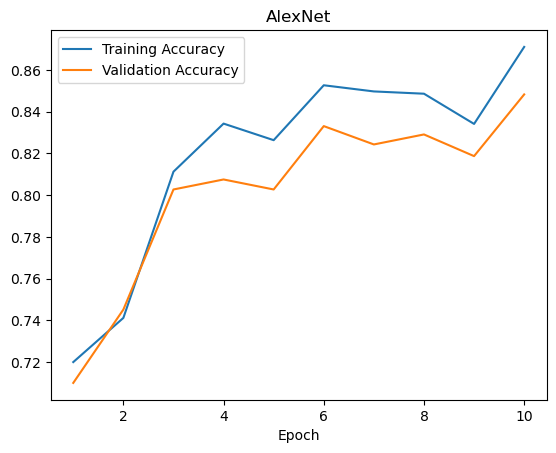

In [ ]:
# Load in each model checkpoint, evaluate, and plot scores
training_score = []
validation_score = []

for i in range(1,11):
  # Load model
  loaded_model = torchvision.models.alexnet()
  loaded_model.load_state_dict(torch.load(f"checkpoints/AlexNet_checkpoint_epoch{i}.pth"))

  # Training data accuracy (can be run with just CPU!!)
  score = evaluate_classifier(loaded_model, train_loader)
  training_score.append(score)

  # Validation data accuracy (can be run with just CPU!!)
  score = evaluate_classifier(loaded_model, val_loader)
  validation_score.append(score)

plt.plot(range(1,11), training_score, label='Training Accuracy')
plt.plot(range(1,11), validation_score, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.title('AlexNet')
plt.show()

alex_validation_score = validation_score

In [ ]:
print(validation_score[5])

0.8330670926517572


We note a clear plateau after about 6 epochs, accordingly 6 epochs seems to give a good accuracy of 0.833 without risk with overfitting.

# Comparing Models

We plot the validation accuract results for all models in the same plot to visualize their performance:

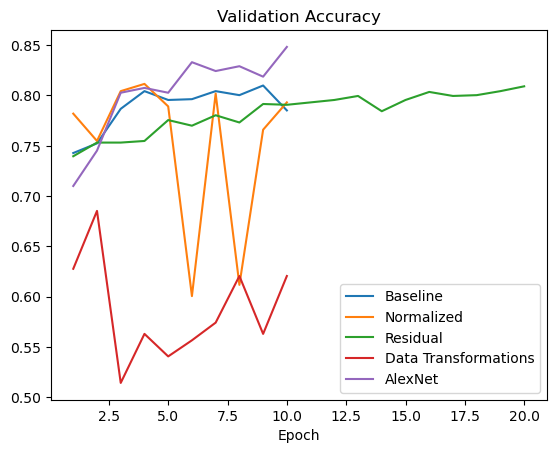

In [ ]:
plt.plot(range(1,11), baseline_validation_score, label='Baseline')
plt.plot(range(1,11), normalized_validation_score, label='Normalized')
plt.plot(range(1,21), residualconnection_validation_score, label='Residual')
plt.plot(range(1,11), transformed_validation_score, label='Data Transformations')
plt.plot(range(1,11), alex_validation_score, label='AlexNet')
plt.legend()
plt.xlabel('Epoch')
plt.legend()
plt.title('Validation Accuracy')
plt.show()

We note that AlexNet performs best overall, but it is interesting to see that our baseline is the second best performer. We also see that the model using normalization has a lot of crazy variation in its accuracy, and we see that the model using residual is the opposite, being very stable and a slow increase in accuracy with increasing epochs.

Because AlexNet perfomed the best we train this model again, but for more epochs as it displays a trend of increasing accuracy on the validation set to see if we can find the absolute best model on this data:

In [ ]:
# Load pre-trained model
weights_id = torchvision.models.AlexNet_Weights.IMAGENET1K_V1
our_model = torchvision.models.alexnet(weights=weights_id)
hyperparams = {
    'lr': 1e-3,
    'n_epochs': 30
    }

# Train model with our data (Run with GPU when entire dataset!!)
train_classifier(model=our_model, train_data=train_loader, hyperparams=hyperparams)

Running Epoch 1...: 100%|██████████| 101/101 [00:51<00:00,  1.97it/s]


Epoch 1 complete. Loss: 96.36329752206802



Running Epoch 2...: 100%|██████████| 101/101 [00:51<00:00,  1.95it/s]


Epoch 2 complete. Loss: 47.569944858551025



Running Epoch 3...: 100%|██████████| 101/101 [00:51<00:00,  1.97it/s]


Epoch 3 complete. Loss: 43.46892875432968



Running Epoch 4...: 100%|██████████| 101/101 [00:51<00:00,  1.97it/s]


Epoch 4 complete. Loss: 41.57316279411316



Running Epoch 5...: 100%|██████████| 101/101 [00:52<00:00,  1.91it/s]


Epoch 5 complete. Loss: 42.57998399436474



Running Epoch 6...: 100%|██████████| 101/101 [00:52<00:00,  1.91it/s]


Epoch 6 complete. Loss: 39.035793617367744



Running Epoch 7...: 100%|██████████| 101/101 [00:51<00:00,  1.94it/s]


Epoch 7 complete. Loss: 40.286801777780056



Running Epoch 8...: 100%|██████████| 101/101 [00:52<00:00,  1.93it/s]


Epoch 8 complete. Loss: 37.26378184556961



Running Epoch 9...: 100%|██████████| 101/101 [00:54<00:00,  1.87it/s]


Epoch 9 complete. Loss: 36.0173402428627



Running Epoch 10...: 100%|██████████| 101/101 [00:52<00:00,  1.92it/s]


Epoch 10 complete. Loss: 34.21458387374878



Running Epoch 11...: 100%|██████████| 101/101 [00:51<00:00,  1.96it/s]


Epoch 11 complete. Loss: 35.964962258934975



Running Epoch 12...: 100%|██████████| 101/101 [00:52<00:00,  1.93it/s]


Epoch 12 complete. Loss: 32.873552829027176



Running Epoch 13...: 100%|██████████| 101/101 [00:53<00:00,  1.90it/s]


Epoch 13 complete. Loss: 32.629409819841385



Running Epoch 14...: 100%|██████████| 101/101 [00:52<00:00,  1.91it/s]


Epoch 14 complete. Loss: 31.696869030594826



Running Epoch 15...: 100%|██████████| 101/101 [00:52<00:00,  1.91it/s]


Epoch 15 complete. Loss: 30.760717496275902



Running Epoch 16...: 100%|██████████| 101/101 [00:53<00:00,  1.90it/s]


Epoch 16 complete. Loss: 29.807201489806175



Running Epoch 17...: 100%|██████████| 101/101 [00:53<00:00,  1.89it/s]


Epoch 17 complete. Loss: 28.20653124153614



Running Epoch 18...: 100%|██████████| 101/101 [00:53<00:00,  1.89it/s]


Epoch 18 complete. Loss: 29.19251787662506



Running Epoch 19...: 100%|██████████| 101/101 [00:53<00:00,  1.88it/s]


Epoch 19 complete. Loss: 28.120191007852554



Running Epoch 20...: 100%|██████████| 101/101 [00:54<00:00,  1.87it/s]


Epoch 20 complete. Loss: 26.808569453656673



Running Epoch 21...: 100%|██████████| 101/101 [00:53<00:00,  1.88it/s]


Epoch 21 complete. Loss: 26.01382327079773



Running Epoch 22...: 100%|██████████| 101/101 [00:54<00:00,  1.86it/s]


Epoch 22 complete. Loss: 26.995000801980495



Running Epoch 23...: 100%|██████████| 101/101 [00:53<00:00,  1.89it/s]


Epoch 23 complete. Loss: 27.226947404444218



Running Epoch 24...: 100%|██████████| 101/101 [00:53<00:00,  1.89it/s]


Epoch 24 complete. Loss: 24.29077299684286



Running Epoch 25...: 100%|██████████| 101/101 [00:53<00:00,  1.90it/s]


Epoch 25 complete. Loss: 23.954605370759964



Running Epoch 26...: 100%|██████████| 101/101 [00:52<00:00,  1.92it/s]


Epoch 26 complete. Loss: 23.109197430312634



Running Epoch 27...: 100%|██████████| 101/101 [00:54<00:00,  1.85it/s]


Epoch 27 complete. Loss: 20.81101132929325



Running Epoch 28...: 100%|██████████| 101/101 [00:54<00:00,  1.85it/s]


Epoch 28 complete. Loss: 26.519181847572327



Running Epoch 29...: 100%|██████████| 101/101 [00:53<00:00,  1.88it/s]


Epoch 29 complete. Loss: 22.05304178595543



Running Epoch 30...: 100%|██████████| 101/101 [00:53<00:00,  1.88it/s]


Epoch 30 complete. Loss: 20.202761627733707

Finished Training


Running evaluation...: 100%|██████████| 20/20 [00:02<00:00,  7.87it/s]


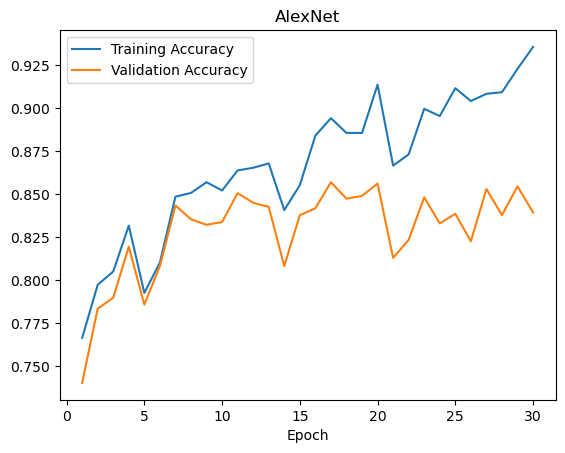

In [ ]:
# Load in each model checkpoint, evaluate, and plot scores
training_score = []
validation_score = []

for i in range(1,31):
  # Load model
  loaded_model = torchvision.models.alexnet()
  loaded_model.load_state_dict(torch.load(f"checkpoints/AlexNet_checkpoint_epoch{i}.pth"))

  # Training data accuracy (can be run with just CPU!!)
  score = evaluate_classifier(loaded_model, train_loader)
  training_score.append(score)

  # Validation data accuracy (can be run with just CPU!!)
  score = evaluate_classifier(loaded_model, val_loader)
  validation_score.append(score)

plt.plot(range(1,31), training_score, label='Training Accuracy')
plt.plot(range(1,31), validation_score, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.title('AlexNet')
plt.show()

alex_validation_score = validation_score

In [ ]:
print(validation_score[6])

0.8434504792332268


We see that the epoch value with best validation accuracy without to much overfitting is 7. After this, validation accuracy does not seem to increase in the long term, so it is no use increasing the value as this would just lead to overfitting on the training data. At 7 epoch, we achieve an accuracy of 0.843 on the validation data.

# Evaluating on the test set

Our best performing model on the validation set was *AlexNet* pre-trained with weights *IMAGENET1K_V1*, and trained for 7 epochs on our training data. We therefore use it on the blind test set and save the scores:

In [ ]:
# Load model
loaded_model = torchvision.models.alexnet()
loaded_model.load_state_dict(torch.load('checkpoints/AlexNet_checkpoint_epoch7.pth'))
loaded_model.eval()

# Load test data
test_folder = ImageFolder('a5_data/test_blind', transform=torchvision.transforms.ToTensor())
test_loader = DataLoader(test_folder, batch_size=16, shuffle=False)

# Run evaluation on blind test data
pred = []
for Xbatch, Ybatch in tqdm(test_loader, desc="Running evaluation..."):
    outputs = loaded_model(Xbatch)
    _, predictions = torch.max(outputs, 1)
    pred.extend(predictions.numpy())

# Save to file
with open("output.txt", "w") as txt_file:
    for line in pred:
        txt_file.write("" + ('NV' if line else 'MEL') + "\n")

# Remove last blank line
with open("output.txt", 'rb+') as filehandle:
    filehandle.seek(-1, os.SEEK_END)
    filehandle.truncate()

Running evaluation...: 100%|██████████| 86/86 [00:07<00:00, 11.15it/s]


*The output file should be a plain text file where each line corresponds to a prediction, in the same order as the numerical order of the files in the test set directory. The labels should be MEL and NV corresponding to melanoma and nevus, respectively. You can use the following code snippet to check that your submission uses the right format:*

In [ ]:
with open("output.txt") as f:
    guesses = [l.strip() for l in f]
    assert(len(guesses) == 1366)
    assert(sorted(set(guesses)) == ['MEL', 'NV'])